In [1]:
import numpy as np
import os, sys

project_root = os.path.abspath("")  # alternative
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import zarr

from utils import remove_all_ticks_and_labels

# training a 10 neuron model for a 3d manifold. 

plot the 3d swiss roll dataset (in 10D) without any rotation. And then plot the same dataset that has been rotated in all 10 dimensions. 

size of the training set is 2000
torch.Size([2000, 10])
size of the training set is 2000


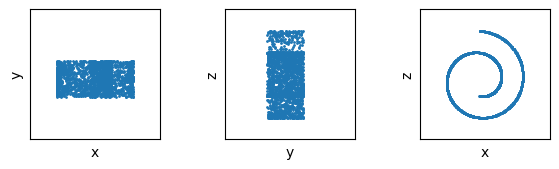

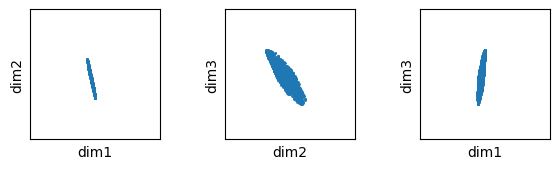

In [2]:
# dataset
from dataset_utils import load_unimodal_data_nd

n_points = int(2e3)

# 2D dataset (not rotated)
dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=0, noise=0, shrink_y_axis=True)
print(dataset.shape)

lim=1.5
lims=[-lim, lim]
fig, axes = plt.subplots(1, 3, figsize=(6, 2))
ax = axes[0]
ax.scatter(*dataset[:, :2].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='x', ylabel='y')

ax = axes[1]
ax.scatter(*dataset[:, 1:3].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='y', ylabel='z')

ax = axes[2]
ax.scatter(*dataset[:, (0,2)].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='x', ylabel='z')
fig.tight_layout()
for ax in axes:
    remove_all_ticks_and_labels(ax)


# rotated dataset
dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)
fig, axes = plt.subplots(1, 3, figsize=(6, 2))
ax = axes[0]
ax.scatter(*dataset[:, :2].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='dim1', ylabel='dim2')

ax = axes[1]
ax.scatter(*dataset[:, 1:3].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='dim2', ylabel='dim3')

ax = axes[2]
ax.scatter(*dataset[:, (0,2)].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='dim1', ylabel='dim3')
fig.tight_layout()
for ax in axes:
    remove_all_ticks_and_labels(ax)

now see if you can do PCA on the rotated dataset to extract a 2D swiss roll 

(2000, 2)
[0.49232887 0.41664731]
[27.26171982 25.07898105]
[[-0.02982921  0.11777657  0.01670307 -0.52242209  0.55015949  0.09558012
  -0.09090004  0.01594413  0.23483042  0.58013937]
 [-0.07085396  0.31658243 -0.36740208 -0.20974097  0.46270896  0.02997833
  -0.17552277 -0.18396912 -0.25567658 -0.60889904]]


[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

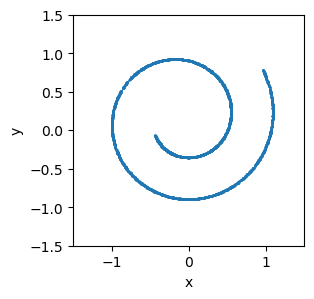

In [3]:
# performing PCA on the rotated dataset
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(dataset)
dataset_2d =pca.transform(dataset)
print(dataset_2d.shape)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.components_)

# plotting the PCA
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(*dataset_2d[:, :2].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='x', ylabel='y')

Good, we get a 2D swiss roll by projecting the dataset onto the top 2 components.
 
If we use PCA on the model output, this is what we want the generated samples to look like.

We trained a 10 neuron model on the 3d dataset. At least qualitatively, we see that it approximates the training dataset well.

Using device: cpu
model loaded!
size of the training set is 2000
torch.Size([101, 1000, 10])


[(-1.5, 1.5), (-1.5, 1.5), None]

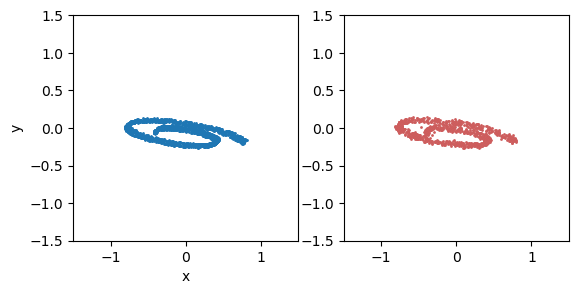

In [4]:
# compare the model output vs ground truth dataset
dim1 = 4
dim2 = 7

# load model and weights
global device
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

from utils import select_model
model, num_steps, dim_amb = select_model('unconditional-dendritic', 58)
model = model.to(device)

dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)

fig, ax = plt.subplots(1, 2)
ax[0].scatter(*dataset[:, (dim1, dim2)].T, s=1)
ax[0].set(xlim=lims, ylim=lims, aspect='equal')
ax[0].set(xlabel='x', ylabel='y')

from prior_utils import p_sample_loop
sample_size = int(1e3)
x_seq = p_sample_loop(model, (sample_size, dim_amb), 100, device=device, init_x=None, normalized_beta_schedule=False)
print(x_seq.shape)


cur_x = x_seq[100].detach().cpu()
ax[1].scatter(cur_x[:, dim1], cur_x[:, dim2],color='white',edgecolor='indianred', s=1)
ax[1].set(xlim=lims, ylim=lims, aspect='equal')


We now perform PCA on the model output and project the data onto the top two components, just like we did on the dataset above. 

(1000, 2)


[(-1.5, 1.5), (-1.5, 1.5), None]

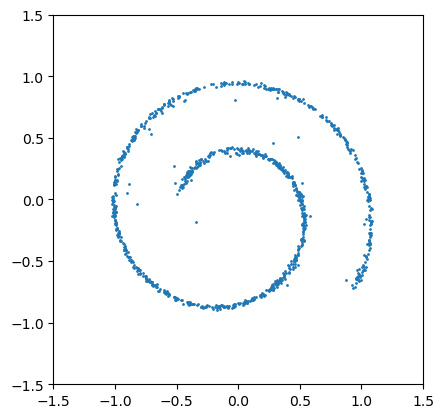

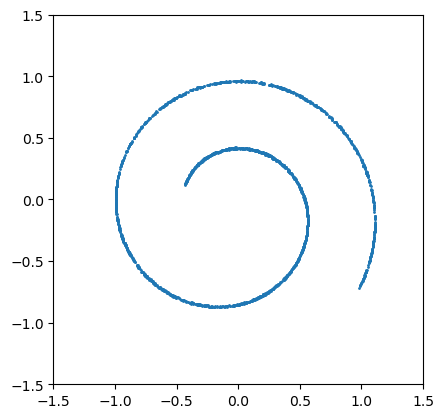

In [5]:
# now perform PCA on the model output
model_output = x_seq[100].detach().cpu()

pca = PCA(n_components=2)
pca.fit(model_output)
x_seq_2d = pca.transform(model_output)
print(x_seq_2d.shape)
eigvalues = pca.components_

fig, ax = plt.subplots(1, 1)
ax.scatter(*x_seq_2d[:, :2].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')


dataset_2d = (eigvalues @ dataset.detach().cpu().numpy().T).T
fig, ax = plt.subplots(1, 1)
ax.scatter(*dataset_2d.T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')


What we see is that the principle components are not perfectly parallel with the perpendicular cross section of the swiss roll. We see varying levels of thickness in the spiral. 

Instead, we can calculate the "ground truth" principle components by rotating the basis vectors by the same rotation operator as the dataset.  

We first show what the projected dataset should look like by projecting a non-rotated dataset onto the non-rotated basis vectors. Note that the basis vectors are orthogonal to the face of the swiss roll. 

(2, 10)
size of the training set is 2000
(2000, 10)
(2, 2000)
(100,)
(2, 10, 100)


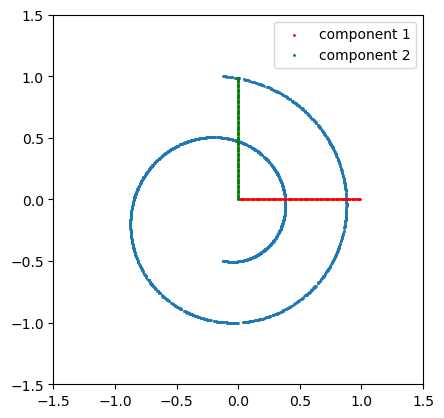

In [5]:
# we want to plot the basis vectors of the cross section of the swiss roll. 
original_basis = np.eye(10)[(0, 2), :]
print(original_basis.shape)

dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=0, noise=0, shrink_y_axis=True)
dataset = dataset.detach().cpu().numpy()
print(dataset.shape)

# project the 10D dataset onto the 2D basis
unrotated_dataset = original_basis @ dataset.T
print(unrotated_dataset.shape)

fig, ax = plt.subplots(1, 1)
ax.set(aspect='equal', xlim=lims, ylim=lims)
ax.scatter(*unrotated_dataset, s=1)

ls = np.arange(0, 1, 0.01)
print(ls.shape)
basis_vectors = np.tensordot(original_basis, ls, axes=0)
print(basis_vectors.shape)

ax.scatter(basis_vectors[0, 0, :], basis_vectors[1, 0, :], color='red', s=1, label='component 1')
ax.scatter(basis_vectors[0, 2, :], basis_vectors[1, 2, :], color='green', s=1, label='component 2')
ax.legend()

We can rotate these basis vectors (above) by the same rotation operator as the rotated 3d swiss roll manifold. 

When the rotated manifold is projected onto these rotated basis vectors, we should be able to recover the original 2d swiss roll. 

(2, 10)
size of the training set is 2000
(2, 500)


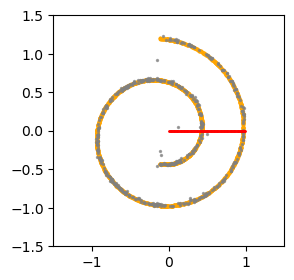

In [7]:
# the basis vectors are rotated by np.pi/4 around each pair of axes 

# ------------------------ construct the basis vectors ----------------------- #
# rotate the basis vectors by np.pi/4 for each dimension
from dataset_utils import rotate_manifold
n_dims = 10
theta = np.pi/4
rotated_basis = original_basis
# for every axis pair, rotate the vector by angle theta
for i in range(0, n_dims-1):
    for j in range(i+1, n_dims):
        rotated_basis = rotate_manifold(rotated_basis, n_dims, i, j, theta)
rotated_basis = np.array(rotated_basis)
print(rotated_basis.shape)


# ----------------------------------- plot ----------------------------------- #
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.set(aspect='equal', xlim=lims, ylim=lims)
# remove_all_ticks_and_labels(ax)

# project the rotated dataset on the rotated basis vectors
rotated_dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)
rotated_dataset = rotated_dataset.detach().cpu().numpy()
projected_rotated_dataset = rotated_basis @ rotated_dataset.T
ax.scatter(*projected_rotated_dataset, s=3, c='orange')

# now project the model output onto these rotated basis vectors
model_output = x_seq[100].detach().cpu().numpy()[:500, :]
projected_model_output = rotated_basis @ model_output.T
print(projected_model_output.shape)
ax.scatter(*projected_model_output, s=2, c='grey', alpha=0.7)

ax.scatter(basis_vectors[0, 0, :], basis_vectors[1, 0, :], color='red', s=1, label='component 1')

plotting the DM samples during the reverse process, for a 3D manifold

(101, 1000, 10)


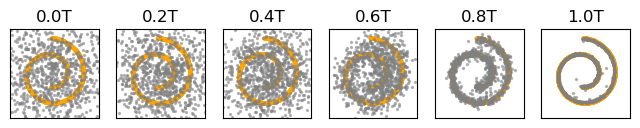

In [8]:
model_output = x_seq.detach().cpu().numpy()
print(model_output.shape)
temps = [0, 20, 40, 60, 80, 100]
fig, ax = plt.subplots(1, len(temps), figsize=(8,3))

for i, t in enumerate(temps):
    projected_model_output = rotated_basis @ model_output[t].T
    
    ax[i].scatter(*projected_rotated_dataset, s=3, c='orange')
    ax[i].scatter(*projected_model_output, s=2, c='grey', alpha=0.5)
    ax[i].set(aspect='equal', xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax[i])
    ax[i].set(title=f'{t/100}T')

In [26]:
# generate samples using neural sampling
# --------------- sample from the prior using neural forward and reverse processes -------------- #
from prior_utils import sequential_prior_sampler
from dataset_utils import load_unimodal_data_nd

# sample_size = int(1e3)
# x_seq = p_sample_loop(model, (sample_size, dim_amb), 100, device=device, init_x=None, normalized_beta_schedule=False)


num_cycles = int(5e2)
# gt_manifold = generate_2d_swiss_roll(int(1e3), True)[1]
swiss_roll_3d = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)
init_x = swiss_roll_3d[0].reshape(-1, 10)
seq_x, seq_fwd_x, seq_rev_x = sequential_prior_sampler(model, init_x, num_cycles, normalized_beta_schedule=False)

size of the training set is 2000


  0%|          | 0/500 [00:00<?, ?it/s]

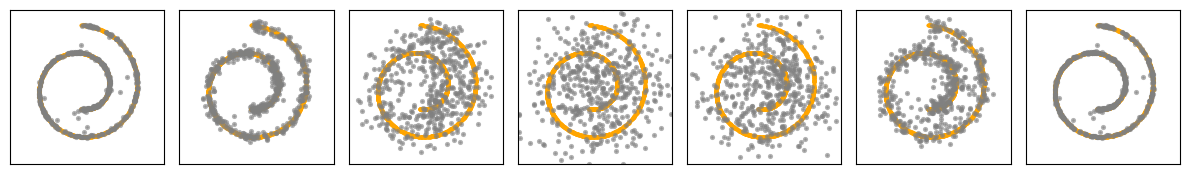

In [77]:
# intermediate steps during the forward/reverse processes
lim = 1.5
lims = [-lim, lim]
swiss_roll_projected = (rotated_basis @ swiss_roll_3d.detach().cpu().numpy().T).T

# Forward process
temps = [0, 25, 50, 100]
fig, axes = plt.subplots(1, len(temps)*2-1, figsize=(12,4))
ax = axes[0:4]
for i, t in enumerate(temps):
    seq_fwd_projected = rotated_basis @ seq_fwd_x[:500,t].T
    ax[i].scatter(*swiss_roll_projected.T, s=3, color='orange')
    ax[i].scatter(*seq_fwd_projected, s=3, lw=2, alpha=0.6, color='grey')
    
for a in ax:
    a.set_aspect('equal')
    a.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(a)
    

# Reverse process
ax = axes[4:]
for i, t in enumerate(reversed(temps[:-1])):
    seq_rev_projected = rotated_basis @ seq_rev_x[:500,100-t].T
    ax[i].scatter(*swiss_roll_projected.T, s=3, color='orange')
    ax[i].scatter(*seq_rev_projected, s=3, lw=2, alpha=0.6, color='grey')

for a in ax:
    a.set_aspect('equal')
    a.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(a)

fig.tight_layout()

from plot import save_fig
save_fig(fig, 'figure1A-3d_manifold.png')
    